In [1]:
# counts frequency of sponsor-cosponsor + cosponsor-cosponsor pairs
import pandas as pd
import re

# data cleaning
df = pd.read_csv("legislation_data.csv")
df = df[['bill_number', 'bill_title', "sponsor_name", "cosponsors", "num_cosponsors", "history"]]
df = df.dropna(subset=['sponsor_name', 'cosponsors'])
df = df.replace({", Jr.": " Jr."}, regex=True)
df = df.replace({", III": " III"}, regex=True)
df = df.replace({", II": " II"}, regex=True)

df

# work together
from itertools import combinations
from collections import Counter

def split_cosponsors(cosponsors):
    if pd.isna(cosponsors):
        return []
    return [name.strip() for name in cosponsors.split(',')]

pairs = []
for _, row in df.iterrows():
    sponsor = row['sponsor_name'].strip()
    cosponsors = split_cosponsors(row['cosponsors'])
    pairs.extend([(sponsor, cosponsor) for cosponsor in cosponsors])
    pairs.extend(list(combinations(cosponsors, 2)))
pair_counts = Counter(pairs)

pair_df = pd.DataFrame(
    [(name1, name2, freq) for (name1, name2), freq in pair_counts.items()],
    columns=['name1', 'name2', 'frequency']
)
pair_df = pair_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
pair_df = pair_df[pair_df['name1'] != pair_df['name2']]
pair_df.to_csv("q2_work_together.csv", index = False)
df

bill_number                                         bill_title  \
0          H.4147  An Act providing technical education and econo...   
2          H.3682               An Act amending the Medal of Liberty   
4          H.2990        An Act to encourage Massachusetts residency   
5          H.1345  An Act relative to establishing institutional ...   
6          S.1799  An Act exempting zero-emission commercial vehi...   
...           ...                                                ...   
70594      S.1098  An Act strengthening prescription drug safety ...   
70595      H.1444  An Act providing a bone marrow registry for fi...   
70597        S.27           An Act relative to juvenile justice data   
70600      S.1132  An Act authorizing the city of Leominster to p...   
70601      H.3029  An Act to protect property of elder or disable...   

                sponsor_name  \
0      Harrington, Sheila C.   
2           Murray, Brian W.   
4        Livingstone, Jay D.   
5      Jones Jr., Bradley H.   
6        Barrett, Michael J.   
...                      ...   
70594        Keenan, John F.   
70595        Ryan, Daniel J.   
70597     Boncore, Joseph A.   
70600  Flanagan, Jennifer L.   
70601          Brodeur, Paul   

                                              cosponsors  num_cosponsors  \
0      Lindsay N. Sabadosa, Mathew J. Muratore, Micha...               3   
2      Michael J. Soter, Jeffrey N. Roy, Colleen M. G...               7   
4                                        Carlos González               1   
5      Susan Williams Gifford, Paul K. Frost, Mathew ...               4   
6      Jason M. Lewis, Lindsay N. Sabadosa, Michael O...               3   
...                                                  ...             ...   
70594  James M. Cantwell, Jason M. Lewis, Robert M. K...              13   
70595  Colleen M. Garry, Frank A. Moran, Angelo J. Pu...              30   
70597  Marjorie C. Decker, Daniel J. Ryan, Sal N. DiD...               9   
70600                                    Natalie Higgins               1   
70601  Jason M. Lewis, Steven S. Howitt, Steven Ultri...               7   

                                                 history  
0      9/30/2021: House - Referred to the committee o...  
2      3/29/2021: House - Referred to the committee o...  
4      3/29/2021: House - Referred to the committee o...  
5      3/29/2021: House - Referred to the committee o...  
6      3/29/2021: Senate - Referred to the committee ...  
...                                                  ...  
70594  1/23/2017: Senate - Referred to the committee ...  
70595  1/23/2017: House - Referred to the committee o...  
70597  1/23/2017: Senate - Referred to the committee ...  
70600  1/23/2017: Senate - Referred to the committee ...  
70601  1/23/2017: House - Referred to the committee o...  

[29464 rows x 6 columns]

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.clique import find_cliques

top = 100
# Identify the top 30 legislators based on total co-sponsorship occurrences
top_legislators = (pair_df.groupby("name1")["frequency"].sum() +
                   pair_df.groupby("name2")["frequency"].sum()).nlargest(top).index

# Filter the pair_df to include only edges where both legislators are in the top 30
filtered_df = pair_df[pair_df["name1"].isin(top_legislators) & pair_df["name2"].isin(top_legislators)]

In [11]:
pair_df.shape

(150839, 3)

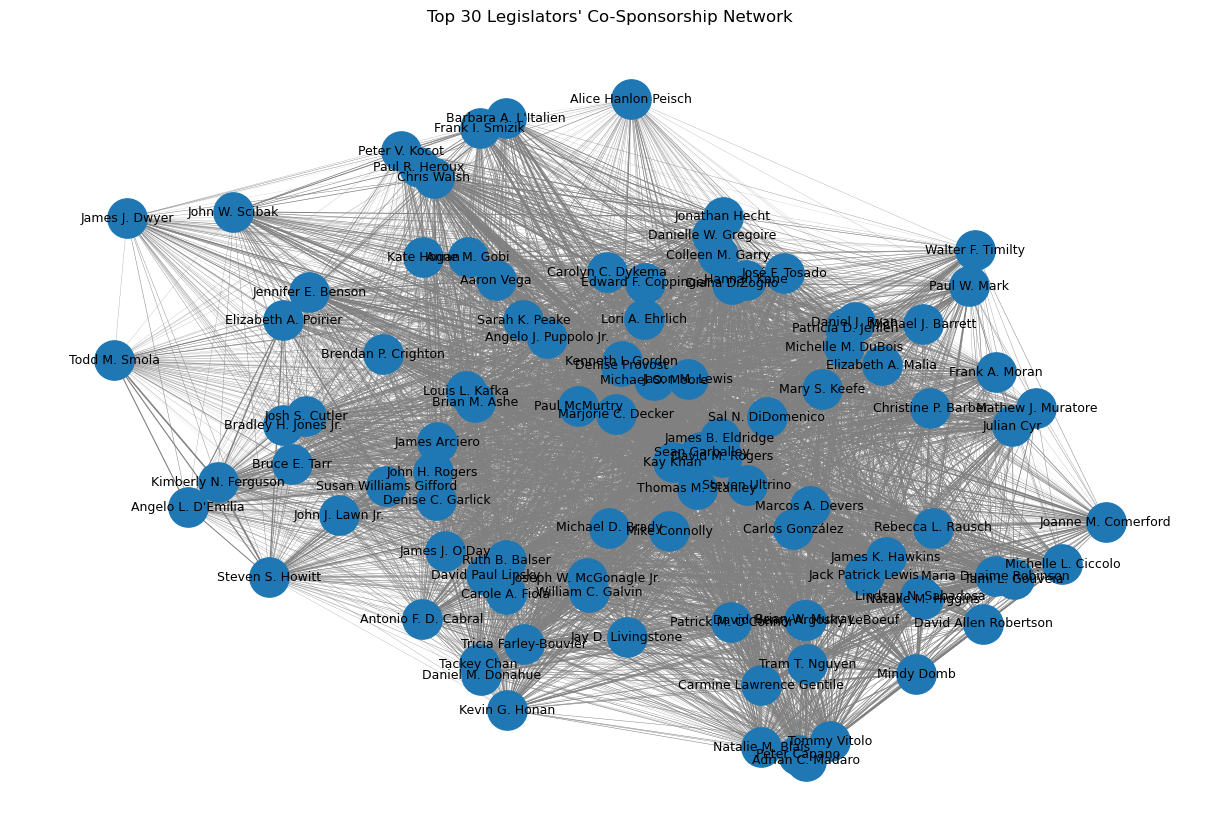

In [5]:
# Create Graph
G = nx.Graph()

# Add edges with weights
for _, row in filtered_df.iterrows():
    G.add_edge(row["name1"], row["name2"], weight=row["frequency"])

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
edges = G.edges(data=True)
weights = [edata["weight"] / 200 for _, _, edata in edges]  # Normalize weights for visibility

nx.draw(G, pos, with_labels=True, node_size=800, font_size=9, edge_color="gray", width=weights)
plt.title("Top 30 Legislators' Co-Sponsorship Network")
plt.show()

/var/folders/0j/rbz5rs0s53d4qdn_g_8bd7lw0000gn/T/ipykernel_72765/273059226.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


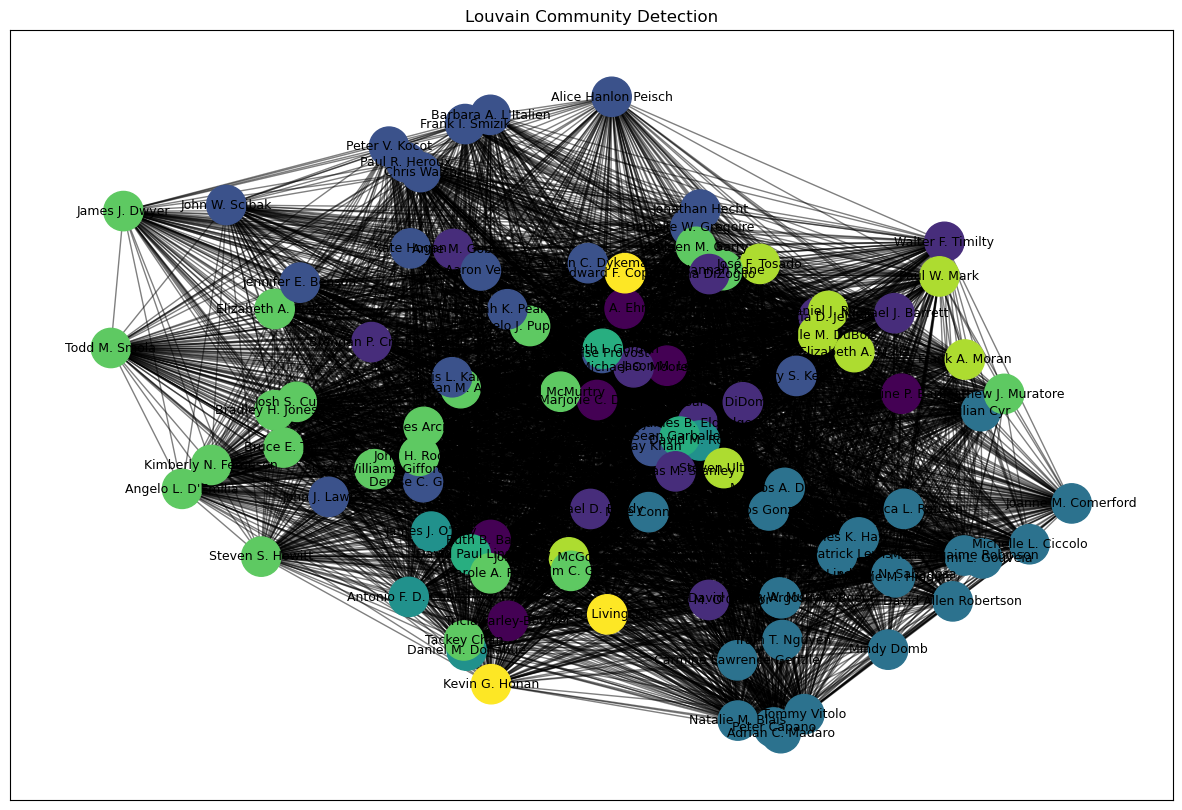

In [6]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt


partition = community_louvain.best_partition(G, resolution=1.2)
plt.figure(figsize=(15, 10))

# Visualize the communities with different colors
pos = nx.spring_layout(G, seed=42)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, node_size=800, cmap=cmap, 
                       node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Louvain Community Detection")
plt.show()

/var/folders/0j/rbz5rs0s53d4qdn_g_8bd7lw0000gn/T/ipykernel_72765/1481972588.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


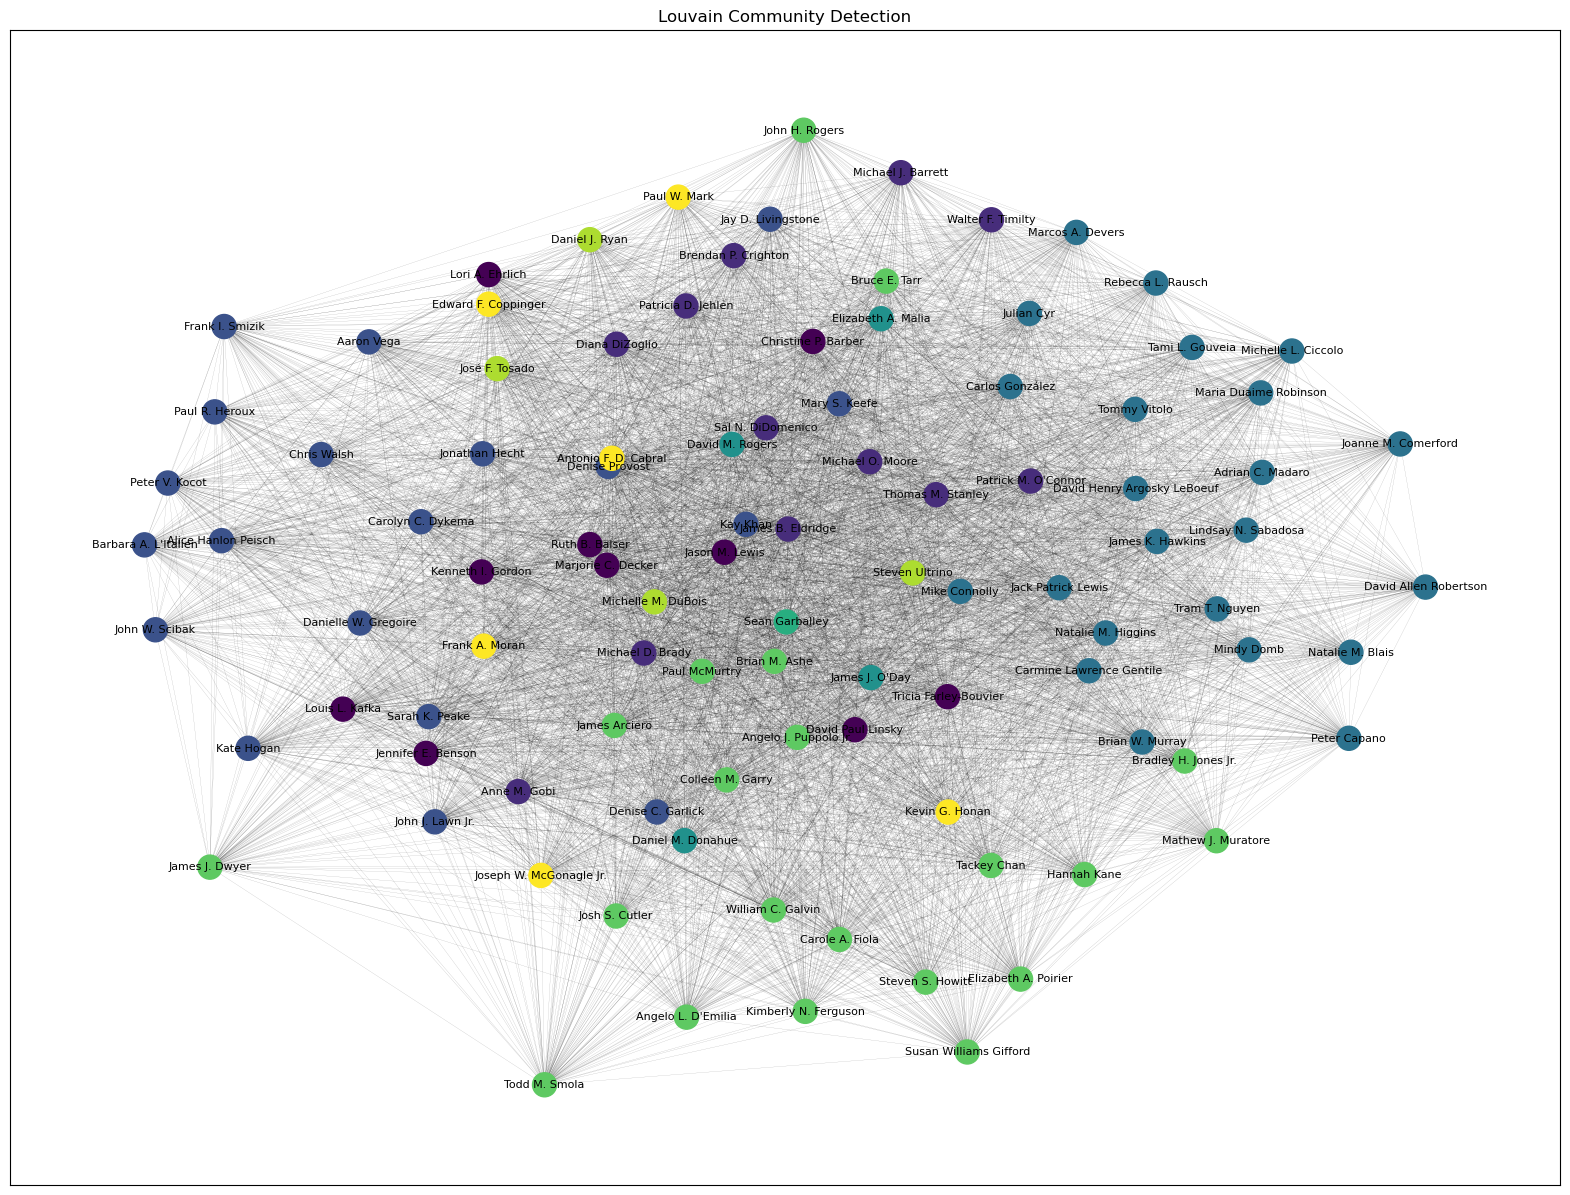

In [27]:
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Compute the partition
partition = community_louvain.best_partition(G, resolution=1.2)

# Increase figure size for better visualization
plt.figure(figsize=(20, 15))

# Adjust the layout to spread nodes more (increase k value)
pos = nx.spring_layout(G, seed=42, k=0.3)  # Higher k spreads out nodes

# Define colormap
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

# Draw nodes with smaller size
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=cmap, 
                       node_color=list(partition.values()))

# Draw edges with reduced thickness (thinner)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.1)

# Draw labels with appropriate font size
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Louvain Community Detection")
plt.show()

In [21]:
# Increase the resolution to get smaller communities; try 1.5 or higher
partition = community_louvain.best_partition(G, resolution=1.3)

# Group nodes by their community label
groups = {}
for node, comm in partition.items():
    groups.setdefault(comm, []).append(node)

# Print the groups with their sizes
for comm, nodes in groups.items():
    print(f"Group {comm} (size {len(nodes)}): {nodes}")

Group 2 (size 16): ['Jason M. Lewis', 'Kay Khan', 'Denise Provost', 'Marjorie C. Decker', 'Ruth B. Balser', 'Jonathan Hecht', 'Jennifer E. Benson', 'Kenneth I. Gordon', 'Carolyn C. Dykema', 'Louis L. Kafka', 'Lori A. Ehrlich', 'Frank I. Smizik', 'Peter V. Kocot', 'Sarah K. Peake', 'John W. Scibak', 'Kate Hogan']
Group 1 (size 10): ['James B. Eldridge', 'Sal N. DiDomenico', 'Patricia D. Jehlen', 'Thomas M. Stanley', 'Michael O. Moore', "Patrick M. O'Connor", 'Michael J. Barrett', 'Walter F. Timilty', 'Anne M. Gobi', 'Brendan P. Crighton']
Group 3 (size 22): ['Lindsay N. Sabadosa', 'Natalie M. Higgins', 'Jack Patrick Lewis', 'Mike Connolly', 'Rebecca L. Rausch', 'Tommy Vitolo', 'Carmine Lawrence Gentile', 'James K. Hawkins', 'David Henry Argosky LeBoeuf', 'Carlos González', 'Joanne M. Comerford', 'Tram T. Nguyen', 'Brian W. Murray', 'Adrian C. Madaro', 'Maria Duaime Robinson', 'Michelle L. Ciccolo', 'Tami L. Gouveia', 'Mindy Domb', 'Peter Capano', 'David Allen Robertson', 'Natalie M. Bla

In [ ]:
people who work together (sponors and cosponsors)
each persons top 10 words from title
